# Tallinn and Helsinky. How similar or dissimilar they are?

["Tallinn Base Map: Tallinn’s subdistrict boundaries"](http://www.tallinn.ee/est/g6497s92804)

https://ogre.adc4gis.com/


Source: [District Map of the City of Helsinki](https://hri.fi/data/en_GB/dataset/helsingin-kaupunginosat).  The maintainer of the dataset is Helsingin kaupunkiympäristön toimiala / Kaupunkimittauspalvelut. The dataset has been downloaded from [Helsinki Region Infoshare](https://hri.fi/) service on 22.11.2019 under the license [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/).

https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json

### Install packages and load libraries

In [13]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle json

In [3]:
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge pyproj --yes 

In [14]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# transform geo coordinates
from pyproj import Proj, transform

In [15]:
#!conda config --set ssl_verify false 
#!conda install -c conda-forge folium=0.5.0 --yes

In [16]:
import folium # plotting library
print(folium.__version__)

0.5.0


## Tallinn

Let's load geo data and create map with district boundaries and pandas dataframe with district names and coordiantes.

To load geo data I use ["Tallinn Base Map: Tallinn’s subdistrict boundaries"](http://www.tallinn.ee/est/g6497s92804) resource to download shape files for boundaries and then with [ogre web site](https://ogre.adc4gis.com/) covert it to geojson format.
> NB! Because of shape file contains coordiantes in Estonian Coordinate System (EPSG:3301) use appropriate options to covert coordinates in World Geodetic System (EPSG:4326)
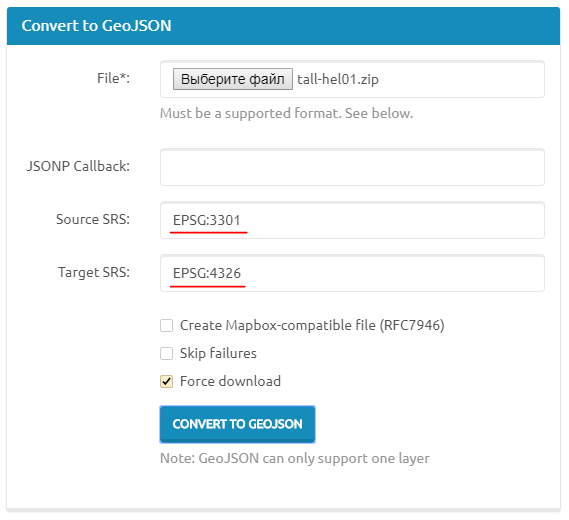
  
As a result I get json file renamed to *tallinn_geo_converted.json*.  
To create dataframe I walk through this file getting district name and using geopy library to define coordinates. First, let's create function for getting coordinates by address:

In [17]:
def coordinates(geolocator, district_name, address_pattern):
    address = address_pattern.format(district_name)
    location = geolocator.geocode(address, timeout=20)
    latitude = location.latitude
    longitude = location.longitude
        
    return location.latitude, location.longitude

In [18]:
# define Tallinn coordiantes
address = 'Tallinn, Etonia'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address, timeout=10)
tallinn_latitude = location.latitude
tallinn_longitude = location.longitude
print(tallinn_latitude, tallinn_longitude)

59.4372155 24.7453688


Done. It's time for dataframe:

In [59]:
with open('tallinn_geo_converted.json', encoding='utf-8') as json_data:
    tallinn_data = json.load(json_data)

tallinn_districts = []
features = tallinn_data['features']
for feature in features:
    properties = feature['properties']
    latitude, longitude  = coordinates(geolocator, 
                                       district_name='{},{}'.format(properties['asumi_nimi'], properties['linnaosa_n']),
                                       address_pattern='{}, Tallinn, Estonia')
    tallinn_districts.append([properties['linna_nimi'],properties['linnaosa_n'],properties['asumi_nimi'], latitude, longitude])
tallinn_districts[0:5]

[['Tallinna linn', 'Kesklinna linnaosa', 'Raua', 59.4364562, 24.768514],
 ['Tallinna linn', 'Pirita linnaosa', 'Iru', 59.4616235, 24.9044609],
 ['Tallinna linn', 'Lasnamäe linnaosa', 'Seli', 59.4442151, 24.893329],
 ['Tallinna linn', 'Lasnamäe linnaosa', 'Sõjamäe', 59.4245821, 24.8434934],
 ['Tallinna linn', 'Nõmme linnaosa', 'Kivimäe', 59.3780192, 24.6559073]]

In [60]:
df_tallinn = pd.DataFrame(tallinn_districts, columns=['City','Borough','Neighborhood', 'Latitude', 'Longitude'])
df_tallinn.head(10)

City                  Borough Neighborhood   Latitude  Longitude
0  Tallinna linn       Kesklinna linnaosa         Raua  59.436456  24.768514
1  Tallinna linn          Pirita linnaosa          Iru  59.461624  24.904461
2  Tallinna linn        Lasnamäe linnaosa         Seli  59.444215  24.893329
3  Tallinna linn        Lasnamäe linnaosa      Sõjamäe  59.424582  24.843493
4  Tallinna linn           Nõmme linnaosa      Kivimäe  59.378019  24.655907
5  Tallinna linn        Lasnamäe linnaosa    Kuristiku  59.451492  24.866185
6  Tallinna linn  Põhja-Tallinna linnaosa   Pelguranna  59.454976  24.688860
7  Tallinna linn           Nõmme linnaosa         Hiiu  59.383453  24.671893
8  Tallinna linn  Põhja-Tallinna linnaosa    Merimetsa  59.434183  24.695458
9  Tallinna linn       Kesklinna linnaosa     Kompassi  59.435810  24.760920

In [87]:
df_tallinn.describe(include='all')

City             Borough Neighborhood   Latitude  Longitude
count              84                  84           84  84.000000  84.000000
unique              1                   8           84        NaN        NaN
top     Tallinna linn  Kesklinna linnaosa         Seli        NaN        NaN
freq               84                  21            1        NaN        NaN
mean              NaN                 NaN          NaN  59.431217  24.749062
std               NaN                 NaN          NaN   0.031762   0.083144
min               NaN                 NaN          NaN  59.354481  24.570101
25%               NaN                 NaN          NaN  59.413300  24.688378
50%               NaN                 NaN          NaN  59.432154  24.746623
75%               NaN                 NaN          NaN  59.446211  24.812205
max               NaN                 NaN          NaN  59.581319  24.904461

In [107]:
import os

if os.path.exists("tallinn_heighborhoods.csv"):
    print('tallinn_heighborhoods.csv exists')
else:
    df_tallinn.to_csv('tallinn_heighborhoods.csv', encoding='utf-8')

tallinn_heighborhoods.csv exists


In [61]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=12) # generate map centred around the Tallinn
#tallinn_markers = folium.map.FeatureGroup()
# add markers to map
def style_function(feature):
    return {
        'color' : '#2222FF',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

folium.GeoJson('tallinn_geo_converted.json', style_function=style_function).add_to(tallinn_map)
for lat, lng, label in zip(df_tallinn['Latitude'], df_tallinn['Longitude'], df_tallinn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tallinn_map)  
tallinn_map

Let's correct some coordinates:

Pirita - 59.468293, 24.834434
Mähe - 59.482542, 24.852122
Tondiraba - 59.442126, 24.859120
Pae - 59.435165, 24.822060
Uuslinn - 59.437080, 24.803290
Juhkentali - 59.425090, 24.769411
Veerenni - 59.424482, 24.749281
Kitseküla - 59.414870, 24.739392
Tondi - 59.408026, 24.724908
Lilleküla - 59.419546, 24.712606
Siili - 59.406715, 24.706119
Sääse - 59.409706, 24.695449
Pelguranna - 59.447834, 24.692225
Mustjõe - 59.428602, 24.680109
Veskimetsa - 59.420996, 24.660690
Liiva - 59.382957, 24.731037
Laagri - 59.355412, 24.619176
Vana-Mustamäe - 59.390358, 24.645816
Astangu - 59.402235, 24.627247
Kopli - 59.459025, 24.673429
Nõmme - 59.379267, 24.694357
Väo - 59.435219, 24.897147
Haabersti - 59.427789, 24.643465
Pikaliiva - 59.429962, 24.612633

In [19]:
df_tallinn = pd.read_csv('tallinn_heighborhoods.csv', encoding='utf-8')
df_tallinn.head(10)

Unnamed: 0           City                  Borough Neighborhood   Latitude  \
0           0  Tallinna linn       Kesklinna linnaosa         Raua  59.436456   
1           1  Tallinna linn          Pirita linnaosa          Iru  59.461624   
2           2  Tallinna linn        Lasnamäe linnaosa         Seli  59.444215   
3           3  Tallinna linn        Lasnamäe linnaosa      Sõjamäe  59.424582   
4           4  Tallinna linn           Nõmme linnaosa      Kivimäe  59.378019   
5           5  Tallinna linn        Lasnamäe linnaosa    Kuristiku  59.451492   
6           6  Tallinna linn  Põhja-Tallinna linnaosa   Pelguranna  59.447834   
7           7  Tallinna linn           Nõmme linnaosa         Hiiu  59.383453   
8           8  Tallinna linn  Põhja-Tallinna linnaosa    Merimetsa  59.434183   
9           9  Tallinna linn       Kesklinna linnaosa     Kompassi  59.435810   

   Longitude  
0  24.768514  
1  24.904461  
2  24.893329  
3  24.843493  
4  24.655907  
5  24.866185  
6  24.692225  
7  24.671893  
8  24.695458  
9  24.760920

In [20]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=12) # generate map centred around the Tallinn
#tallinn_markers = folium.map.FeatureGroup()
# add markers to map
def style_function(feature):
    return {
        'color' : '#2222FF',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

folium.GeoJson('tallinn_geo_converted.json', style_function=style_function).add_to(tallinn_map)
for lat, lng, label in zip(df_tallinn['Latitude'], df_tallinn['Longitude'], df_tallinn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tallinn_map)  
tallinn_map

## Helsinki

Let's make similar geodata preparation for Helsinki. Lucky me, we are able to get geo data in geojson format for city of Helsinki using [Helsinki Region Infoshare](https://hri.fi/) service. Just submit query [District Map of the City of Helsinki]( https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json)

In [11]:
# create the API request URL
url = 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json'
# make the GET request
results = requests.get(url, verify=False).json() #["response"]['groups'][0]['items']
results

C:\Anaconda3\envs\tf\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


{'crs': {'properties': {'name': 'urn:ogc:def:crs:EPSG::3879'}, 'type': 'name'},
 'features': [{'geometry': {'coordinates': [[[25492719.1749788,
       6673875.36173711],
      [25493462.4188057, 6673254.25743011],
      [25494394.4998769, 6674325.42935366],
      [25494755.1112754, 6674739.85199555],
      [25494764.1390835, 6674733.95520776],
      [25494810.7195735, 6674713.9245289],
      [25494885.5238174, 6674688.29867894],
      [25494905.4748441, 6674679.77538749],
      [25494931.1226707, 6674715.96874126],
      [25494933.6189781, 6674719.49160006],
      [25494955.6747853, 6674768.94252281],
      [25494969.9170829, 6674797.60227495],
      [25494975.4507747, 6674808.21030174],
      [25494994.504058, 6674842.55900518],
      [25495010.1555411, 6674868.80799026],
      [25495027.3856417, 6674895.83486853],
      [25495044.4458555, 6674920.8750735],
      [25495054.5521003, 6674934.89696398],
      [25495065.6345284, 6674950.07856765],
      [25495091.8888605, 6674983.9534184]

As we see geo coordinates introduced in local coordinate system (espg:3879). We have translate it to World Geodetic System (EPSG:4326).  
So, let's create functions:

In [22]:
def covert_coordinates(json_data, output_file, in_epsg='epsg:3879', out_epsg='epsg:4326'):
    inProj = Proj(init=in_epsg) # epsg:3879 - finland
    outProj = Proj(init=out_epsg)# epsg:4326 WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS
    features = json_data['features']
    features[0]
    for feature in features:
        geometry = feature['geometry']
        print(geometry['type'], np.shape(geometry['coordinates']))
        Polygons = []
        if geometry['type'] == 'MultiPolygon' :
            Polygons = geometry['coordinates']
        else:
            Polygons.append(geometry['coordinates'])

        for polygon in Polygons:
            points = polygon[0]
            for point in points:
                point[0],point[1] = transform(inProj,outProj,point[0],point[1])

            
    with open(output_file, "w", encoding='utf-8') as write_file:
        json.dump(json_data, write_file, ensure_ascii=False)

def covert_coordinates_in_file(input_file, output_file, in_epsg='epsg:3879', out_epsg='epsg:4326'):
    with open(input_file, encoding='utf-8') as json_data:
        epsg_data = json.load(json_data)

    convert_coordinates(espg_data, output_file, in_epsg, out_epsg)


In [23]:
covert_coordinates(results, 'helsinki_geo_converted.json', in_epsg='epsg:3879', out_epsg='epsg:4326')

Polygon (1, 99, 2)
Polygon (1, 123, 2)
Polygon (1, 122, 2)
Polygon (1, 1492, 2)
Polygon (1, 138, 2)
Polygon (1, 83, 2)
Polygon (1, 322, 2)
Polygon (1, 10, 2)
Polygon (1, 126, 2)
Polygon (1, 287, 2)
Polygon (1, 218, 2)
Polygon (1, 443, 2)
Polygon (1, 593, 2)
Polygon (1, 219, 2)
Polygon (1, 491, 2)
Polygon (1, 28, 2)
Polygon (1, 219, 2)
Polygon (1, 819, 2)
Polygon (1, 343, 2)
Polygon (1, 76, 2)
Polygon (1, 87, 2)
Polygon (1, 16, 2)
Polygon (1, 140, 2)
Polygon (1, 19, 2)
Polygon (1, 359, 2)
Polygon (1, 39, 2)
Polygon (1, 173, 2)
Polygon (1, 281, 2)
Polygon (1, 103, 2)
Polygon (1, 35, 2)
Polygon (1, 223, 2)
Polygon (1, 97, 2)
Polygon (1, 147, 2)
Polygon (1, 21, 2)
Polygon (1, 121, 2)
Polygon (1, 65, 2)
Polygon (1, 58, 2)
Polygon (1, 35, 2)
Polygon (1, 958, 2)
Polygon (1, 29, 2)
Polygon (1, 85, 2)
Polygon (1, 39, 2)
Polygon (1, 20, 2)
Polygon (1, 312, 2)
Polygon (1, 114, 2)
Polygon (1, 364, 2)
Polygon (1, 51, 2)
Polygon (1, 214, 2)
Polygon (1, 99, 2)
Polygon (1, 280, 2)
Polygon (1, 634, 2)


In [29]:
with open('helsinki_geo_converted.json', encoding='utf-8') as json_data:
    helsinki_data = json.load(json_data)

helsinki_districts = []
features = helsinki_data['features']
for feature in features:
    properties = feature['properties']
    #print(properties['yhtdatanomistaja'], properties['tunnus'], properties['nimi_fi'])

    latitude, longitude  = coordinates(geolocator, 
                                       district_name=properties['nimi_fi'],
                                       address_pattern='{}, Helsinki, Finland')
    helsinki_districts.append([properties['yhtdatanomistaja'],properties['tunnus'],properties['nimi_fi'], latitude, longitude])

helsinki_districts[0:5]

[['Helsinki/Kami', '15', 'MEILAHTI', 60.1913479, 24.9026643],
 ['Helsinki/Kami', '43', 'HERTTONIEMI', 60.1955246, 25.0290632],
 ['Helsinki/Kami', '10', 'SÖRNÄINEN', 60.1838848, 24.9644087],
 ['Helsinki/Kami', '55', 'ÖSTERSUNDOM', 60.25960365, 25.1870084785404],
 ['Helsinki/Kami', '21', 'HERMANNI', 60.1966243, 24.9709346]]

In [30]:
df_helsinki = pd.DataFrame(helsinki_districts, columns=['City','Borough','Neighborhood', 'Latitude', 'Longitude'])
df_helsinki.head(10)

City   Borough Neighborhood   Latitude  Longitude
0  Helsinki/Kami        15     MEILAHTI  60.191348  24.902664
1  Helsinki/Kami        43  HERTTONIEMI  60.195525  25.029063
2  Helsinki/Kami        10    SÖRNÄINEN  60.183885  24.964409
3  Helsinki/Kami        55  ÖSTERSUNDOM  60.259604  25.187008
4  Helsinki/Kami        21     HERMANNI  60.196624  24.970935
5  Helsinki/Kami        30  MUNKKINIEMI  60.199094  24.874358
6  Helsinki/Kami        22      VALLILA  60.196167  24.956710
7  Helsinki/Kami  Aluemeri     ALUEMERI  59.999293  25.020178
8  Helsinki/Kami        07   ULLANLINNA  60.158715  24.949404
9  Helsinki/Kami        58   KARHUSAARI  60.172396  25.117952

In [38]:
import os
if os.path.exists("helsinki_heighborhoods.csv"):
    print('helsinki_heighborhoods.csv exists')
else:
    df_helsinki.to_csv('helsinki_heighborhoods.csv', encoding='utf-8')

helsinki_heighborhoods.csv exists


In [31]:
address = 'Helsinki, Finland'

location = geolocator.geocode(address)
helsinki_latitude = location.latitude
helsinki_longitude = location.longitude
print(helsinki_latitude, helsinki_longitude)

60.1674086 24.9425683


In [34]:
helsinki_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11) # generate map centred around the Helsinki
def style_function(feature):
    return {
        'color' : '#2222FF',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

folium.GeoJson('helsinki_geo_converted.json', style_function=style_function).add_to(helsinki_map)
for lat, lng, label in zip(df_helsinki['Latitude'], df_helsinki['Longitude'], df_helsinki['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(helsinki_map)  
helsinki_map

Correct some coordinates:

KARHUSAARI - 60.251099, 25.218480
ULKOSAARET - 60.101523, 25.050689

In [39]:
df_helsinki = pd.read_csv('helsinki_heighborhoods.csv', encoding='utf-8')
df_helsinki.head(10)

Unnamed: 0           City   Borough Neighborhood   Latitude  Longitude
0           0  Helsinki/Kami        15     MEILAHTI  60.191348  24.902664
1           1  Helsinki/Kami        43  HERTTONIEMI  60.195525  25.029063
2           2  Helsinki/Kami        10    SÖRNÄINEN  60.183885  24.964409
3           3  Helsinki/Kami        55  ÖSTERSUNDOM  60.259604  25.187008
4           4  Helsinki/Kami        21     HERMANNI  60.196624  24.970935
5           5  Helsinki/Kami        30  MUNKKINIEMI  60.199094  24.874358
6           6  Helsinki/Kami        22      VALLILA  60.196167  24.956710
7           7  Helsinki/Kami  Aluemeri     ALUEMERI  59.999293  25.020178
8           8  Helsinki/Kami        07   ULLANLINNA  60.158715  24.949404
9           9  Helsinki/Kami        58   KARHUSAARI  60.251099  25.218480

In [47]:
helsinki_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11) # generate map centred around the Helsinki
def style_function(feature):
    return {
        'color' : '#2222FF',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

folium.GeoJson('helsinki_geo_converted.json', style_function=style_function).add_to(helsinki_map)
for lat, lng, label in zip(df_helsinki['Latitude'], df_helsinki['Longitude'], df_helsinki['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(helsinki_map)  
helsinki_map

## Clustering

Next, I'm going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [48]:
CLIENT_ID = 'WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR' # your Foursquare ID
CLIENT_SECRET = '2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK' # your Foursquare Secret
VERSION = '20191118' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Let's combine city dataframes together:

In [59]:
df_neighborhoods = pd.concat([df_tallinn, df_helsinki], ignore_index=True)
df_neighborhoods.drop('Unnamed: 0', axis=1, inplace=True)
df_neighborhoods.head()

City             Borough Neighborhood   Latitude  Longitude
0  Tallinna linn  Kesklinna linnaosa         Raua  59.436456  24.768514
1  Tallinna linn     Pirita linnaosa          Iru  59.461624  24.904461
2  Tallinna linn   Lasnamäe linnaosa         Seli  59.444215  24.893329
3  Tallinna linn   Lasnamäe linnaosa      Sõjamäe  59.424582  24.843493
4  Tallinna linn      Nõmme linnaosa      Kivimäe  59.378019  24.655907

In [60]:
df_neighborhoods.describe(include='all')

City             Borough Neighborhood    Latitude   Longitude
count             144                 144          144  144.000000  144.000000
unique              2                  68          144         NaN         NaN
top     Tallinna linn  Kesklinna linnaosa      Priisle         NaN         NaN
freq               84                  21            1         NaN         NaN
mean              NaN                 NaN          NaN   59.751111   24.849389
std               NaN                 NaN          NaN    0.381828    0.147821
min               NaN                 NaN          NaN   59.355412   24.570101
25%               NaN                 NaN          NaN   59.430088   24.730820
50%               NaN                 NaN          NaN   59.454767   24.848001
75%               NaN                 NaN          NaN   60.186473   24.955227
max               NaN                 NaN          NaN   60.283019   25.218480

In [78]:
df_neighborhoods.to_csv('all_heighborhoods.csv', encoding='utf-8')

Let's create a function to generate top 100 venues within a radius of 500 meters for every neighborhoods:

In [ ]:
from time import sleep

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    sleep(2)
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        print(url)    
        # make the GET request
        results = requests.get(url, verify=False).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using function above I create new dataframe:

In [80]:
from requests.packages.urllib3.exceptions import InsecureRequestWarning
# disable ssl warnings
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

tallinn_venues = getNearbyVenues(names=df_tallinn['Neighborhood'],
                                   latitudes=df_tallinn['Latitude'],
                                   longitudes=df_tallinn['Longitude'],
                                   radius=radius
                                  )

Raua
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4364562,24.768514&radius=500&limit=100
Iru
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4616235,24.9044609&radius=500&limit=100
Seli
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.44421510000001,24.893329&radius=500&limit=100
Sõjamäe
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4245821,24.843493399999996&radius=500&limit=100
Kivimäe
https://api.foursquare.com/v2/venues/explore?&client_id=W

Tatari
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4301297,24.7480418&radius=500&limit=100
Torupilli
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4314594,24.776553&radius=500&limit=100
Õismäe
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4380189,24.619423&radius=500&limit=100
Pirita
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.468293,24.834433999999998&radius=500&limit=100
Priisle
https://api.foursquare.com/v2/venues/explore?&client_id=

Astangu
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.402235,24.627247&radius=500&limit=100
Pääsküla
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.3677228,24.640765&radius=500&limit=100
Kakumäe
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4533711,24.5816986&radius=500&limit=100
Sikupilli
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=59.4275586,24.7933117&radius=500&limit=100
Kelmiküla
https://api.foursquare.com/v2/venues/explore?&client_id=WE

In [84]:
tallinn_venues.to_csv('tallinn_venues.csv', encoding='utf-8')
print(tallinn_venues.shape)
tallinn_venues.head()

(1330, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Raua              59.436456               24.768514   
1         Raua              59.436456               24.768514   
2         Raua              59.436456               24.768514   
3         Raua              59.436456               24.768514   
4         Raua              59.436456               24.768514   

                 Venue  Venue Latitude  Venue Longitude Venue Category  
0  Hilton Tallinn Park       59.433892        24.768677          Hotel  
1         SaltRestoran       59.435093        24.773610     Restaurant  
2    Faehlmanni kohvik       59.434709        24.773160           Café  
3            Surfhouse       59.435853        24.765265     Board Shop  
4    Bogi Hookah Place       59.438529        24.770771         Lounge

Let's check how many venues were returned for each neighborhood:

In [82]:
tallinn_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                          
Aegna                              1                       1      1   
Astangu                            1                       1      1   
Haabersti                         13                      13     13   
Hiiu                               4                       4      4   
Iru                                5                       5      5   
Juhkentali                        12                      12     12   
Järve                             13                      13     13   
Kadaka                            21                      21     21   
Kadriorg                          35                      35     35   
Kakumäe                            1                       1      1   
Kalamaja                          19                      19     19   
Karjamaa                          15                      15     15   
Kassisaba                         36                      36     36   
Katleri                            4                       4      4   
Keldrimäe                         45                      45     45   
Kelmiküla                         64                      64     64   
Kitseküla                         20                      20     20   
Kivimäe                            8                       8      8   
Kloostrimetsa                      4                       4      4   
Kompassi                          86                      86     86   
Kopli                              6                       6      6   
Kose                               5                       5      5   
Kurepõllu                          4                       4      4   
Kuristiku                          9                       9      9   
Laagna                             8                       8      8   
Laagri                             2                       2      2   
Laiaküla                           1                       1      1   
Lepiku                             3                       3      3   
Liiva                              2                       2      2   
Lilleküla                          6                       6      6   
...                              ...                     ...    ...   
Rahumäe                           13                      13     13   
Raua                              20                      20     20   
Raudalu                            4                       4      4   
Rocca al Mare                      3                       3      3   
Sadama                            26                      26     26   
Seli                               5                       5      5   
Sibulaküla                        71                      71     71   
Siili                             14                      14     14   
Sikupilli                         23                      23     23   
Sitsi                              7                       7      7   
Sääse                             15                      15     15   
Sõjamäe                            7                       7      7   
Südalinn                         100                     100    100   
Tatari                            43                      43     43   
Tiskre                             4                       4      4   
Tondi                              5                       5      5   
Tondiraba                         12                      12     12   
Torupilli                         32                      32     32   
Tõnismäe                          19                      19     19   
Uus Maailm                        27                      27     27   
Uuslinn                           10                      10     10   
Vana-Mustamäe                      9                       9      9   
Vanalinn                         100                     100    100   
Veerenni                          29   

In [86]:
helsinki_venues = getNearbyVenues(names=df_helsinki['Neighborhood'],
                                   latitudes=df_helsinki['Latitude'],
                                   longitudes=df_helsinki['Longitude'],
                                   radius=radius
                                  )

MEILAHTI
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.1913479,24.9026643&radius=500&limit=100
HERTTONIEMI
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.195524600000006,25.0290632&radius=500&limit=100
SÖRNÄINEN
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.1838848,24.9644087&radius=500&limit=100
ÖSTERSUNDOM
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.25960365,25.187008478540395&radius=500&limit=100
HERMANNI
https://api.foursquare.com/v2/v

ETU-TÖÖLÖ
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.1740311,24.9223027&radius=500&limit=100
KAIVOPUISTO
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.1568425,24.9567212&radius=500&limit=100
LAAJASALO
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.1732049,25.044919699999998&radius=500&limit=100
TAMMISALO
https://api.foursquare.com/v2/venues/explore?&client_id=WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR&client_secret=2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK&v=20191118&ll=60.1914529,25.059291899999998&radius=500&limit=100
SUUTARILA
https://api.foursquare.com/v2/ve

In [87]:
helsinki_venues.to_csv('helsinki_venues.csv', encoding='utf-8')
print(helsinki_venues.shape)
helsinki_venues.head()

(1428, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     MEILAHTI              60.191348               24.902664   
1     MEILAHTI              60.191348               24.902664   
2     MEILAHTI              60.191348               24.902664   
3     MEILAHTI              60.191348               24.902664   
4     MEILAHTI              60.191348               24.902664   

                       Venue  Venue Latitude  Venue Longitude  \
0             Bon Temps Café       60.193400        24.906200   
1                   UniSport       60.189964        24.897268   
2                   Mullikka       60.193260        24.907090   
3   Meilahden liikuntakeskus       60.190003        24.897142   
4  Meilahden frisbeegolfrata       60.190489        24.897613   

         Venue Category  
0           Coffee Shop  
1  Gym / Fitness Center  
2                   Bar  
3  Gym / Fitness Center  
4             Disc Golf

In [88]:
helsinki_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                    
ALPPIHARJU                                  28                      28     28   
EIRA                                        32                      32     32   
ETU-TÖÖLÖ                                   36                      36     36   
HAAGA                                       14                      14     14   
HERMANNI                                     8                       8      8   
HERTTONIEMI                                 31                      31     31   
KAARELA                                      4                       4      4   
KAARTINKAUPUNKI                            100                     100    100   
KAIVOPUISTO                                 29                      29     29   
KALLIO                                      87                      87     87   
KAMPPI                                     100                     100    100   
KARHUSAARI                                   4                       4      4   
KATAJANOKKA                                 36                      36     36   
KLUUVI                                      96                      96     96   
KONALA                                      15                      15     15   
KOSKELA                                     12                      12     12   
KRUUNUNHAKA                                 77                      77     77   
KULOSAARI                                   12                      12     12   
KUMPULA                                      4                       4      4   
KÄPYLÄ                                      12                      12     12   
LAAJASALO                                    6                       6      6   
LAAKSO                                       4                       4      4   
LAUTTASAARI                                 33                      33     33   
LÄNSISATAMA                                 29                      29     29   
MALMI                                       19                      19     19   
MEILAHTI                                    23                      23     23   
MELLUNKYLÄ                                  18                      18     18   
MUNKKINIEMI                                 20                      20     20   
MUSTIKKAMAA-KORKEASAARI                     11                      11     11   
OULUNKYLÄ                                   12                      12     12   
PAKILA                                       4                       4      4   
PASILA                                      19                      19     19   
PITÄJÄNMÄKI                                 12                      12     12   
PUKINMÄKI                                   13                      13     13   
PUNAVUORI                                  100                     100    100   
RUSKEASUO                                   12                      12     12   
SALMENKALLIO                                 2                       2      2   
SANTAHAMINA                                  5                       5      5   
SUOMENLINNA                                 27                      27     27   
SUURMETSÄ                                    7                       7      7   
SUUTARILA                                    5                       5      5   
SÖRNÄINEN                                   29                      29     29   
TAKA-TÖÖLÖ                                  31                      31     31   
TALOSAARI                                    1                       1      1   
TAMMISALO                                    4                       4      4   
TAPANINKYLÄ                                  4                       4      4   
TOUKOLA                                     22                      22     22   
TUOMARINKYLÄ                                 5          

In [90]:
df_venues = pd.concat([tallinn_venues, helsinki_venues], ignore_index=True)
#df_venues.drop('Unnamed: 0', axis=1, inplace=True)
df_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Raua              59.436456               24.768514   
1         Raua              59.436456               24.768514   
2         Raua              59.436456               24.768514   
3         Raua              59.436456               24.768514   
4         Raua              59.436456               24.768514   

                 Venue  Venue Latitude  Venue Longitude Venue Category  
0  Hilton Tallinn Park       59.433892        24.768677          Hotel  
1         SaltRestoran       59.435093        24.773610     Restaurant  
2    Faehlmanni kohvik       59.434709        24.773160           Café  
3            Surfhouse       59.435853        24.765265     Board Shop  
4    Bogi Hookah Place       59.438529        24.770771         Lounge

In [91]:
df_venues.to_csv('all_venues.csv', encoding='utf-8')

In [92]:
df_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                            
ALPPIHARJU                          28                      28     28   
Aegna                                1                       1      1   
Astangu                              1                       1      1   
EIRA                                32                      32     32   
ETU-TÖÖLÖ                           36                      36     36   
HAAGA                               14                      14     14   
HERMANNI                             8                       8      8   
HERTTONIEMI                         31                      31     31   
Haabersti                           13                      13     13   
Hiiu                                 4                       4      4   
Iru                                  5                       5      5   
Juhkentali                          12                      12     12   
Järve                               13                      13     13   
KAARELA                              4                       4      4   
KAARTINKAUPUNKI                    100                     100    100   
KAIVOPUISTO                         29                      29     29   
KALLIO                              87                      87     87   
KAMPPI                             100                     100    100   
KARHUSAARI                           4                       4      4   
KATAJANOKKA                         36                      36     36   
KLUUVI                              96                      96     96   
KONALA                              15                      15     15   
KOSKELA                             12                      12     12   
KRUUNUNHAKA                         77                      77     77   
KULOSAARI                           12                      12     12   
KUMPULA                              4                       4      4   
Kadaka                              21                      21     21   
Kadriorg                            35                      35     35   
Kakumäe                              1                       1      1   
Kalamaja                            19                      19     19   
...                                ...                     ...    ...   
TAPANINKYLÄ                          4                       4      4   
TOUKOLA                             22                      22     22   
TUOMARINKYLÄ                         5                       5      5   
Tatari                              43                      43     43   
Tiskre                               4                       4      4   
Tondi                                5                       5      5   
Tondiraba                           12                      12     12   
Torupilli                           32                      32     32   
Tõnismäe                            19                      19     19   
ULKOSAARET                           6                       6      6   
ULLANLINNA                          57                      57     57   
ULTUNA                               4                       4      4   
Uus Maailm                          27                      27     27   
Uuslinn                             10                      10     10   
VALLILA                             46                      46     46   
VANHAKAUPUNKI                       16                      16     16   
VARTIOKYLÄ                          40                      40     40   
VARTIOSAARI                          6                       6      6   
VIIKKI                               9                       9      9   
VUOSAARI                            29                      29     29   
Vana-Mustamäe                        9                       9      9   
Vanalinn                           100                     100    100   
Ve

Let's find out how many unique categories can be curated from all the returned venues:

In [93]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 331 uniques categories.


Using one-hot encoding method I transform dataframe df_venues into dataframe of categoies of venues:

In [94]:
# one hot encoding
df_venue_categories = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_venue_categories['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_venue_categories.columns[-1]] + list(df_venue_categories.columns[:-1])
df_venue_categories = df_venue_categories[fixed_columns]

print(df_venue_categories.shape)
df_venue_categories.head()

(2758, 332)


Neighborhood  Accessories Store  African Restaurant  American Restaurant  \
0         Raua                  0                   0                    0   
1         Raua                  0                   0                    0   
2         Raua                  0                   0                    0   
3         Raua                  0                   0                    0   
4         Raua                  0                   0                    0   

   Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0             0         0       0            0           0   
1             0         0       0            0           0   
2             0         0       0            0           0   
3             0         0       0            0           0   
4             0         0       0            0           0   

   Arts & Crafts Store     ...       Water Park  Waterfront  Whisky Bar  \
0                    0     ...                0           0           0   
1                    0     ...                0           0           0   
2                    0     ...                0           0           0   
3                    0     ...                0           0           0   
4                    0     ...                0           0           0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0         0          0            0              0            0    0   
1         0          0            0              0            0    0   
2         0          0            0              0            0    0   
3         0          0            0              0            0    0   
4         0          0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 332 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category:

In [95]:
df_neighborhood_categories = df_venue_categories.groupby('Neighborhood').mean().reset_index()
df_neighborhood_categories

Neighborhood  Accessories Store  African Restaurant  \
0         ALPPIHARJU           0.000000            0.000000   
1              Aegna           0.000000            0.000000   
2            Astangu           0.000000            0.000000   
3               EIRA           0.000000            0.000000   
4          ETU-TÖÖLÖ           0.000000            0.000000   
5              HAAGA           0.000000            0.000000   
6           HERMANNI           0.000000            0.000000   
7        HERTTONIEMI           0.000000            0.000000   
8          Haabersti           0.000000            0.000000   
9               Hiiu           0.000000            0.000000   
10               Iru           0.000000            0.000000   
11        Juhkentali           0.000000            0.000000   
12             Järve           0.000000            0.000000   
13           KAARELA           0.000000            0.000000   
14   KAARTINKAUPUNKI           0.000000            0.000000   
15       KAIVOPUISTO           0.000000            0.000000   
16            KALLIO           0.000000            0.000000   
17            KAMPPI           0.000000            0.000000   
18        KARHUSAARI           0.000000            0.000000   
19       KATAJANOKKA           0.000000            0.000000   
20            KLUUVI           0.000000            0.000000   
21            KONALA           0.000000            0.000000   
22           KOSKELA           0.000000            0.000000   
23       KRUUNUNHAKA           0.000000            0.000000   
24         KULOSAARI           0.000000            0.000000   
25           KUMPULA           0.000000            0.000000   
26            Kadaka           0.000000            0.000000   
27          Kadriorg           0.000000            0.000000   
28           Kakumäe           0.000000            0.000000   
29          Kalamaja           0.000000            0.000000   
..               ...                ...                 ...   
111      TAPANINKYLÄ           0.000000            0.000000   
112          TOUKOLA           0.000000            0.000000   
113     TUOMARINKYLÄ           0.000000            0.000000   
114           Tatari           0.000000            0.000000   
115           Tiskre           0.000000            0.000000   
116            Tondi           0.000000            0.000000   
117        Tondiraba           0.000000            0.000000   
118        Torupilli           0.000000            0.000000   
119         Tõnismäe           0.000000            0.000000   
120       ULKOSAARET           0.000000            0.000000   
121       ULLANLINNA           0.000000            0.000000   
122           ULTUNA           0.000000            0.000000   
123       Uus Maailm           0.000000            0.000000   
124          Uuslinn           0.000000            0.000000   
125          VALLILA           0.000000            0.021739   
126    VANHAKAUPUNKI           0.000000            0.000000   
127       VARTIOKYLÄ           0.000000            0.000000   
128      VARTIOSAARI           0.000000            0.000000   
129           VIIKKI           0.000000            0.000000   
130         VUOSAARI           0.000000            0.000000   
131    Vana-Mustamäe           0.000000            0.000000   
132         Vanalinn           0.000000            0.000000   
133         Veerenni           0.034483            0.000000   
134       Veskimetsa           0.000000            0.000000   
135       Vismeistri           0.000000            0.000000   
136     Väike-Õismäe           0.000000            0.000000   
137           Õismäe           0.000000            0.000000   
138      ÖSTERSUNDOM           0.000000            0.000000   
139         Ülemiste           0.000000            0.000000   
140    Ülemistejärve           0.000000            0.000000   

     American Restaurant  Antique Shop  Aquarium    Arcade  Art Gallery  \
0                   0.00  

At this point we are ready to split our neigborhoods on several clusters.  

### Clustering heighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [96]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123).fit(neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 3, 2, 2, 1, 2, 1, 2, 1])

In [97]:
print(kmeans.inertia_)

19.6082400273


In [101]:
Ks = 20
inertia = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(n_clusters=n, random_state=123).fit(neighborhood_clustering)
    inertia[n-1] = kmeans.inertia_
inertia

array([ 26.42894323,  23.07249209,  21.75250491,  20.61628856,
        19.60824003,  18.88302792,  17.97505188,  17.39172323,
        15.95484884,  15.76572932,  15.33677736,  14.47346215,
        14.22303082,  14.1324546 ,  13.55426456,  13.71776576,
        12.90009491,  12.75086332,  12.53535157])

#### Plot  model inertia  for Different number of clusters 

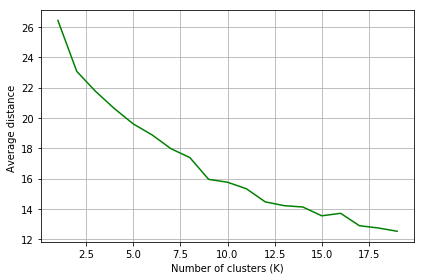

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1,Ks),inertia,'g')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
plt.grid(True)
plt.tight_layout()
plt.show()

Elbow point K=9

In [111]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123).fit(neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([6, 8, 2, 6, 6, 3, 6, 3, 6, 3])

Done! Add cluster labels to neighborhood categories dataframe:

In [112]:
df_neighborhood_categories.insert(0, 'Cluster Label', kmeans.labels_)
df_neighborhood_categories.head()

Cluster Label Neighborhood  Accessories Store  African Restaurant  \
0              6   ALPPIHARJU                0.0                 0.0   
1              8        Aegna                0.0                 0.0   
2              2      Astangu                0.0                 0.0   
3              6         EIRA                0.0                 0.0   
4              6    ETU-TÖÖLÖ                0.0                 0.0   

   American Restaurant  Antique Shop  Aquarium  Arcade  Art Gallery  \
0                  0.0           0.0  0.035714     0.0          0.0   
1                  0.0           0.0  0.000000     0.0          0.0   
2                  0.0           0.0  0.000000     0.0          0.0   
3                  0.0           0.0  0.000000     0.0          0.0   
4                  0.0           0.0  0.000000     0.0          0.0   

   Art Museum     ...       Water Park  Waterfront  Whisky Bar  Wine Bar  \
0         0.0     ...              0.0     0.00000         0.0   0.00000   
1         0.0     ...              0.0     0.00000         0.0   0.00000   
2         0.0     ...              0.0     0.00000         0.0   0.00000   
3         0.0     ...              0.0     0.03125         0.0   0.03125   
4         0.0     ...              0.0     0.00000         0.0   0.00000   

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0        0.0          0.0            0.0     0.000000  0.0          0.0  
1        0.0          0.0            0.0     0.000000  0.0          0.0  
2        0.0          0.0            0.0     0.000000  0.0          0.0  
3        0.0          0.0            0.0     0.000000  0.0          0.0  
4        0.0          0.0            0.0     0.027778  0.0          0.0  

[5 rows x 333 columns]

### Combine data together

Let's add clustering data to neghborhood dataframe for analysis purposes.  To do this I create new column with top 5 venues categories for each neghborhood and then add it to neghborhood dataframe together with cluster labels.
  
First, create function to sort the venues categories in descending order and combine list of them:

In [113]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    # sort values for only present categories
    row_categories_sorted = row_categories.where(row_categories > 0).sort_values(ascending=False)
    try:
        result = row_categories_sorted.index.values[0:num_top_venues]
    except:
        result = row_categories_sorted.index.values
      
    return ','.join(result.tolist())

Let's create new column called 'Top 10' in clustering dataframe:

In [114]:
df_neighborhood_categories['Top 10'] = df_neighborhood_categories.apply(lambda x: return_most_common_venues(x,10), axis=1)

In [115]:
df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']].head(10)

Cluster Label Neighborhood  \
0              6   ALPPIHARJU   
1              8        Aegna   
2              2      Astangu   
3              6         EIRA   
4              6    ETU-TÖÖLÖ   
5              3        HAAGA   
6              6     HERMANNI   
7              3  HERTTONIEMI   
8              6    Haabersti   
9              3         Hiiu   

                                              Top 10  
0  Theme Park Ride / Attraction,Park,Greek Restau...  
1  Campground,Accessories Store,African Restauran...  
2  Bus Stop,Accessories Store,African Restaurant,...  
3  Park,Scandinavian Restaurant,Italian Restauran...  
4  Scandinavian Restaurant,Bakery,Gym,Sushi Resta...  
5  Bus Stop,Sushi Restaurant,Supermarket,Shoe Rep...  
6  Yoga Studio,Sauna / Steam Room,Recycling Facil...  
7  Bus Stop,Gym / Fitness Center,Supermarket,Conv...  
8  Gym / Fitness Center,Clothing Store,Tennis Cou...  
9  Trail,Pool Hall,Flower Shop,Bus Stop,Accessori...

At this point we ready to create new dataframe for all data we have - neighborhoods, geographic coordinates, venue categories and clustering labels. Let's merge it together:

In [119]:
df_tallinn_clustered = df_tallinn.merge(df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']], how='left', on='Neighborhood')
df_tallinn_clustered.drop('Unnamed: 0', axis=1, inplace=True)
df_tallinn_clustered.head()

City             Borough Neighborhood   Latitude  Longitude  \
0  Tallinna linn  Kesklinna linnaosa         Raua  59.436456  24.768514   
1  Tallinna linn     Pirita linnaosa          Iru  59.461624  24.904461   
2  Tallinna linn   Lasnamäe linnaosa         Seli  59.444215  24.893329   
3  Tallinna linn   Lasnamäe linnaosa      Sõjamäe  59.424582  24.843493   
4  Tallinna linn      Nõmme linnaosa      Kivimäe  59.378019  24.655907   

   Cluster Label                                             Top 10  
0            6.0  Restaurant,Café,Wings Joint,Italian Restaurant...  
1            6.0  Shopping Mall,Hookah Bar,Historic Site,Grocery...  
2            3.0  Bus Stop,Fast Food Restaurant,Department Store...  
3            6.0  Food,Supermarket,Furniture / Home Store,Café,B...  
4            6.0  Playground,Train Station,Theme Park,Nightclub,...

In [120]:
df_helsinki_clustered = df_helsinki.merge(df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']], how='left', on='Neighborhood')
df_helsinki_clustered.drop('Unnamed: 0', axis=1, inplace=True)
df_helsinki_clustered.head()

City Borough Neighborhood   Latitude  Longitude  Cluster Label  \
0  Helsinki/Kami      15     MEILAHTI  60.191348  24.902664            6.0   
1  Helsinki/Kami      43  HERTTONIEMI  60.195525  25.029063            3.0   
2  Helsinki/Kami      10    SÖRNÄINEN  60.183885  24.964409            6.0   
3  Helsinki/Kami      55  ÖSTERSUNDOM  60.259604  25.187008            5.0   
4  Helsinki/Kami      21     HERMANNI  60.196624  24.970935            6.0   

                                              Top 10  
0  Bus Stop,Gym / Fitness Center,Bar,Café,Tram St...  
1  Bus Stop,Gym / Fitness Center,Supermarket,Conv...  
2  Bar,Event Space,Recreation Center,Pizza Place,...  
3  Hobby Shop,Accessories Store,African Restauran...  
4  Yoga Studio,Sauna / Steam Room,Recycling Facil...

In [121]:
df_helsinki_clustered.to_csv('helsinki_geo_clustered.csv', encoding='utf-8')
df_tallinn_clustered.to_csv('tallinn_geo_clustered.csv', encoding='utf-8')

#### Finally, let's visualize the resulting clusters.  

In [147]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

# create map
tallinn_clustered_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add black color for outliers
rainbow.append('#000000')

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_tallinn_clustered['Latitude'], df_tallinn_clustered['Longitude'], df_tallinn_clustered['Neighborhood'], df_tallinn_clustered['Cluster Label']):
    if math.isnan(cluster): # outlier
        label = folium.Popup(str(poi) + ' - Outlier', parse_html=True)
        cluster = kclusters
    else:
        label = folium.Popup(str(poi) + ' - Cluster ' + str(int(cluster)), parse_html=True) 
                
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(tallinn_clustered_map)
       
tallinn_clustered_map

In [141]:
# create a plain world map
tallinn_colored_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=11, tiles='Mapbox Bright')
tallinn_colored_map.choropleth(
    geo_data='tallinn_geo_converted.json',
    data=df_tallinn_clustered,
    columns=['Neighborhood', 'Cluster Label'],
    key_on='feature.properties.asumi_nimi',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Tallinn clusters'
)
tallinn_colored_map

In [154]:
# create a plain world map
helsinki_colored_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11, tiles='Mapbox Bright')
helsinki_colored_map.choropleth(
    geo_data='helsinki_geo_converted.json',
    data=df_helsinki_clustered,
    columns=['Neighborhood', 'Cluster Label'],
    key_on='feature.properties.nimi_fi',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Helsinki clusters'
)
helsinki_colored_map

In [128]:
df_neighborhoods_clustered = df_neighborhoods.merge(df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']], how='left', on='Neighborhood')
#df_neighborhoods_clustered.drop('Unnamed: 0', axis=1, inplace=True)
df_neighborhoods_clustered.head()

City             Borough Neighborhood   Latitude  Longitude  \
0  Tallinna linn  Kesklinna linnaosa         Raua  59.436456  24.768514   
1  Tallinna linn     Pirita linnaosa          Iru  59.461624  24.904461   
2  Tallinna linn   Lasnamäe linnaosa         Seli  59.444215  24.893329   
3  Tallinna linn   Lasnamäe linnaosa      Sõjamäe  59.424582  24.843493   
4  Tallinna linn      Nõmme linnaosa      Kivimäe  59.378019  24.655907   

   Cluster Label                                             Top 10  
0            6.0  Restaurant,Café,Wings Joint,Italian Restaurant...  
1            6.0  Shopping Mall,Hookah Bar,Historic Site,Grocery...  
2            3.0  Bus Stop,Fast Food Restaurant,Department Store...  
3            6.0  Food,Supermarket,Furniture / Home Store,Café,B...  
4            6.0  Playground,Train Station,Theme Park,Nightclub,...

In [134]:
df_neighborhoods_clustered[['Cluster Label', 'City','Neighborhood']].groupby(['Cluster Label','City']).count()

Neighborhood
Cluster Label City                       
0.0           Tallinna linn             2
1.0           Helsinki/Kami             1
              Tallinna linn            17
2.0           Helsinki/Kami             2
              Tallinna linn             1
3.0           Helsinki/Kami            14
              Tallinna linn             9
4.0           Helsinki/Kami             3
5.0           Helsinki/Kami             1
6.0           Helsinki/Kami            37
              Tallinna linn            52
7.0           Tallinna linn             1
8.0           Tallinna linn             1

In [148]:
from branca.colormap import linear

In [149]:
colormap = linear.YlGn_09.scale(0,kclusters)

print(colormap(5.0))

colormap

#5fba6c


In [167]:
tallinn_color_dict = df_tallinn_clustered.set_index('Neighborhood')['Cluster Label'].fillna(9)
tallinn_color_dict['Raua']

6.0

In [169]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=11,tiles='Mapbox Bright') # generate map centred around the Tallinn
fg= folium.FeatureGroup(name='My Map')
folium.GeoJson(open('tallinn_geo_converted.json',encoding = 'utf-8').read(), 
    style_function=lambda feature: {
        'fillColor': colormap(tallinn_color_dict[feature['properties']['asumi_nimi']]),
        'color': 'black',
        'weight': 1,
        'nan_fill_color': 'purple',
        'nan_fill_opacity': 0.4,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(tallinn_map)
tallinn_map

In [196]:
helsinki_color_dict = df_helsinki_clustered.set_index('Neighborhood')['Cluster Label'].fillna(9)
helsinki_color_dict['SÖRNÄINEN']
#colormap(helsinki_color_dict['SÖRNÄINEN'])

6.0

In [201]:
from folium.features import DivIcon

helsinki_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11,tiles='Mapbox Bright') # generate map centred around the Tallinn
folium.GeoJson(open('helsinki_geo_converted.json',encoding = 'utf-8').read(), 
    style_function=lambda feature: {
        'fillColor': colormap(helsinki_color_dict[feature['properties']['nimi_fi']]),
        'color': 'black',
        'weight': 1,
        'nan_fill_color': 'purple',
        'nan_fill_opacity': 0.4,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(helsinki_map)

for lat, lon, poi in zip(df_helsinki_clustered['Latitude'], df_helsinki_clustered['Longitude'], df_helsinki_clustered['Neighborhood']):

    '''    iframe = folium.IFrame(poi, width=700, height=450)
    popup = folium.Popup(iframe, max_width=3000)

    Text = folium.Marker(location=[lat,lon], popup=popup,
                     icon=folium.Icon(icon_color='green'))
    helsinki_map.add_child(Text)
    '''
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(helsinki_map)
    folium.map.Marker(
        [lat, lon],
#        popup=poi,
#    [lat+0.005, lon-0.002*len(poi)],
        icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0), html='<div style="font-size: 8pt">%s</div>' % poi,)
    #    icon=folium.Icon(color='black')
    ).add_to(helsinki_map)
helsinki_map